In [1]:
%matplotlib inline
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import Euclid

%erun PHZ_NNPZ 0.12

from nnpz.reference_sample import ReferenceSample

plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
ref_sample = ReferenceSample.ReferenceSample('/home/aalvarez/Work/Data/SC8/SOM_Ex/ref_sample/')

INFO    : Found provider PdzProvider
2021-03-29T14:53:14CEST ReferenceSample  INFO : Found provider PdzProvider
INFO    : Found provider SedProvider
2021-03-29T14:53:15CEST ReferenceSample  INFO : Found provider SedProvider


In [3]:
result = Table.read('/home/aalvarez/Work/Data/SC8/SOM_Ex/develop.fits', hdu=1)

In [4]:
pdz_bins = ref_sample.getPdzData(ref_sample.getIds()[0])[:,0]

In [178]:
np.finfo(np.float32).max

3.4028235e+38

In [223]:
smallest_f32 = np.finfo(np.float32).tiny
biggest_f32 = np.finfo(np.float32).max

def alternate_coadded(nids, nweights):
    pdz = np.zeros((len(pdz_bins), 2), dtype=np.float32)
    pdz[:,0] = pdz_bins
    scale = 1.
    for i, w in zip(nids, nweights):
        if w <= 1e-300:
            continue

        rpdz = ref_sample.getPdzData(i)[:,1].astype(np.float64)
        with np.errstate(over='ignore'):
            rpdz *= w * scale
        rpdz += pdz[:,1]
        
        if np.all(rpdz < smallest_f32) & np.any(rpdz > 0):
            scale = 1/np.max(rpdz)
            rpdz *= scale
        elif np.any(rpdz > biggest_f32):
            rpdz[:] = pdz[:,1]
            rpdz /= scale
            rpdz = ref_sample.getPdzData(i)[:,1].astype(np.float64) * w
            scale = 1/np.max(rpdz)
            rpdz *= scale           
        pdz[:,1] = rpdz
    pdz[:,1] /= np.trapz(pdz[:,1], pdz_bins)
    return pdz

In [224]:
np.argwhere(result['OBJECT_ID'] == 7067671500430002)

array([[6526]])

True

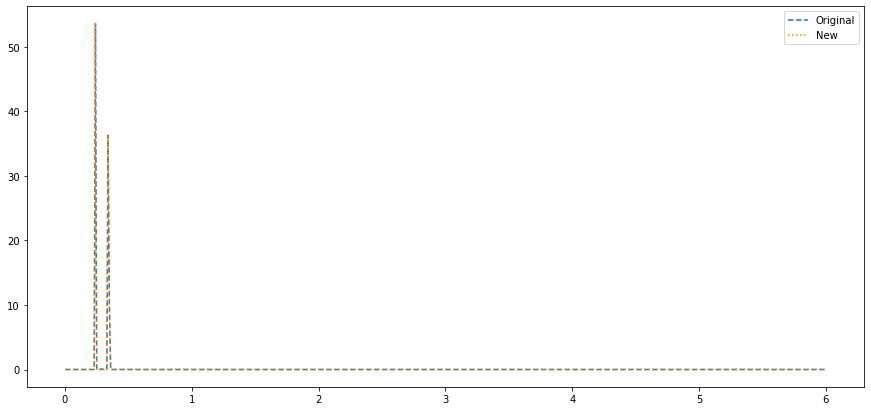

In [225]:
obj = result[6526]
pdz = alternate_coadded(obj['NEIGHBOR_IDS'], obj['NEIGHBOR_WEIGHTS'])
plt.figure()
plt.plot(pdz[:,0], obj['REDSHIFT_PDF'], '--', label='Original')
plt.plot(pdz[:,0], pdz[:,1], ':', label='New')

tw = np.max(obj['NEIGHBOR_WEIGHTS'])
for ni, w in zip(obj['NEIGHBOR_IDS'], obj['NEIGHBOR_WEIGHTS']/tw):
    rp = ref_sample.getPdzData(ni)
#    plt.plot(rp[:,0], rp[:,1]*w, '-', color='gray')
    
plt.legend()

np.isclose(obj['REDSHIFT_PDF'], pdz[:,1]).all()

In [226]:
def plot_pdzs(idx, ax=None, rtol=1e-5, atol=1e-8):
    if ax is None:
        ax = plt.gca()
    new_pdz = alternate_coadded(result['NEIGHBOR_IDS'][idx], result['NEIGHBOR_WEIGHTS'][idx])
    ax.plot(pdz_bins, result['REDSHIFT_PDF'][idx], '-', label='Original')
    ax.plot(new_pdz[:,0], new_pdz[:,1], ':', label='New')
    ax.legend()
    all_equal = np.isclose(new_pdz[:,1], result['REDSHIFT_PDF'][idx], rtol=rtol, atol=atol).all()
    ax.set_title('{} ({})'.format(idx, all_equal))
    return all_equal

True


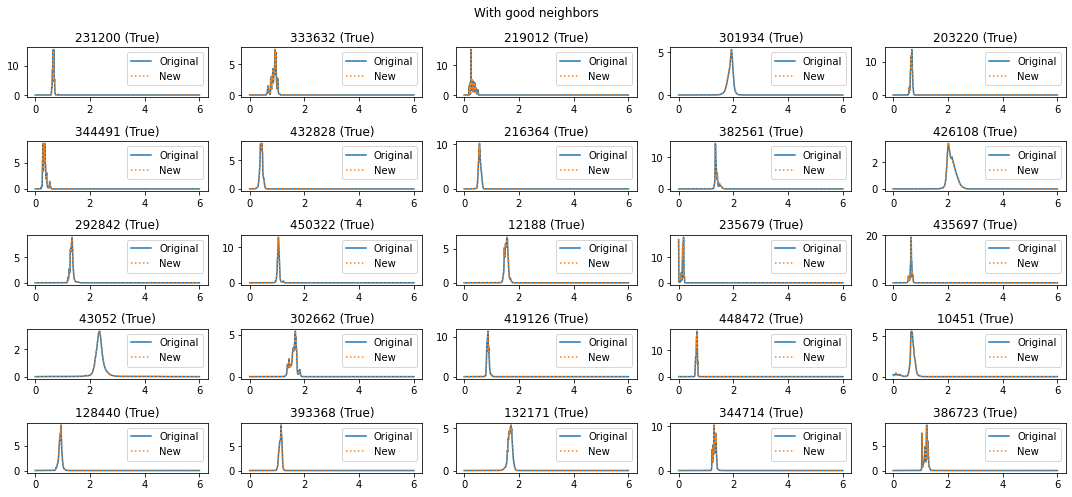

In [227]:
w = np.argwhere((result['NEIGHBOR_WEIGHTS'] > 1e-2).sum(axis=1) >= 30)[:,0]
idxs = np.random.choice(w, 25)

fig, axes = plt.subplots(5, 5)
fig.suptitle('With good neighbors')
eq = []
for idx, ax in zip(idxs, axes.ravel()):
    eq.append(plot_pdzs(idx, ax=ax))
plt.tight_layout()
print(np.all(eq))

36


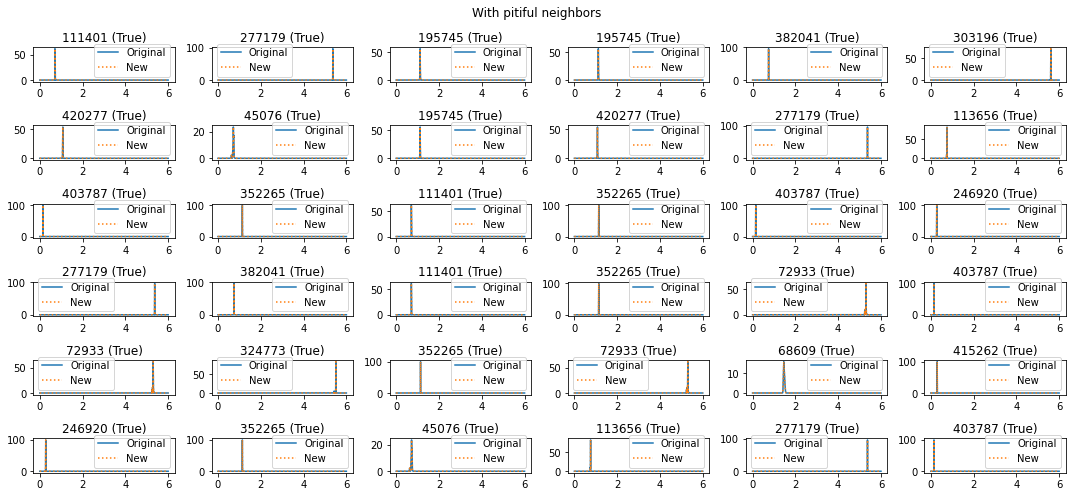

In [228]:
w = np.argwhere((result['NEIGHBOR_WEIGHTS'] < 1e-130).sum(axis=1) >= 30)[:,0]
idxs = np.random.choice(w, 36)

fig, axes = plt.subplots(6, 6)
fig.suptitle('With pitiful neighbors')
eq = []
for idx, ax in zip(idxs, axes.ravel()):
    eq.append(plot_pdzs(idx, ax=ax, rtol=1, atol=1e-1))
plt.tight_layout()
print(np.sum(eq))